# LSTM

In [1]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

# Import Dataset

In [2]:
df = pd.read_csv('../../Datasets/GGRM-long.csv')
df.drop('Volume', inplace=True, axis=1)
df

,Date,Open,High,Low,Close,Adj Close
0,2017-01-02,63900.0,63900.0,63900.0,63900.0,53824.429688
1,2017-01-03,63650.0,64350.0,63100.0,63300.0,53319.035156
2,2017-01-04,63400.0,64450.0,62300.0,63200.0,53234.804688
3,2017-01-05,63200.0,65600.0,63200.0,65600.0,55256.378906
4,2017-01-06,65450.0,65450.0,63900.0,64425.0,54266.652344
...,...,...,...,...,...,...
1257,2021-12-24,30625.0,30625.0,30500.0,30525.0,30525.000000
1258,2021-12-27,30525.0,30800.0,30475.0,30675.0,30675.000000
1259,2021-12-28,30675.0,30850.0,30650.0,30650.0,30650.000000
1260,2021-12-29,30800.0,30825.0,30650.0,30650.0,30650.000000


In [3]:
df.isna().sum()


Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
dtype: int64

In [4]:
df = df.dropna()

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close
count,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000
mean,60509.615385,61197.422680,59790.146709,60453.033307,54605.716865
std,17523.568490,17684.222558,17350.455959,17549.552357,14590.353188
min,30200.000000,30425.000000,29925.000000,30200.000000,30200.000000
25%,44050.000000,44675.000000,43150.000000,44000.000000,41154.226563
50%,65000.000000,65575.000000,64475.000000,64925.000000,55130.035156
75%,76375.000000,77025.000000,75650.000000,76375.000000,67817.664063
max,94300.000000,100975.000000,92600.000000,94400.000000,85359.835938


In [6]:
new_df = df.reset_index()['Close']
new_df

0       63900.0
1       63300.0
2       63200.0
3       65600.0
4       64425.0
         ...   
1256    30525.0
1257    30675.0
1258    30650.0
1259    30650.0
1260    30600.0
Name: Close, Length: 1261, dtype: float64

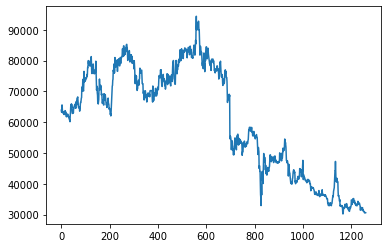

In [7]:
plt.plot(new_df)

# MinMax Scaler

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))
new_df

array([[0.52492212],
       [0.51557632],
       [0.51401869],
       ...,
       [0.00700935],
       [0.00700935],
       [0.00623053]])

# Splitting Training and Testing

In [9]:
training_size = int(len(new_df)*0.8)
test_size = len(new_df)-training_size
train_data, test_data = new_df[0:training_size,:], new_df[training_size:len(new_df),:1]

In [10]:
training_size, test_size

(1008, 253)

In [11]:
xs = new_df

In [12]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
nc      = 4  
Ts      = 5
x_dim   = 1
alpha   = 0.01
epochs  = 200

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   

X_train = xt[:-20, 0:x_dim]     
y_train = xt[:-20, x_dim:x_dim+1]  
X_test = xt[-20:, 0:x_dim]     
y_test = xt[-20:, x_dim:x_dim+1]  

In [13]:
len(X_train)

1240

In [14]:
me = LSTM(x_dim,1,nc)
for i in range(epochs):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.04232192614105892
------------- 2 -------------
0.04230597316781895
------------- 3 -------------
0.04229002487214039
------------- 4 -------------
0.04227408120208416
------------- 5 -------------
0.04225814210510448
------------- 6 -------------
0.042242207528697936
------------- 7 -------------
0.042226277420392665
------------- 8 -------------
0.04221035172773815
------------- 9 -------------
0.04219443039829475
------------- 10 -------------
0.042178513379623486
------------- 11 -------------
0.04216260061927567
------------- 12 -------------
0.042146692064782804
------------- 13 -------------
0.042130787663646425
------------- 14 -------------
0.042114887363327885
------------- 15 -------------
0.042098991111238535
------------- 16 -------------
0.04208309885472954
------------- 17 -------------
0.04206721054108222
------------- 18 -------------
0.04205132611749795
------------- 19 -------------
0.04203544553108846
------------- 20 -------------
0.

0.039787549911413096
------------- 162 -------------
0.039771475788447246
------------- 163 -------------
0.039755392815059715
------------- 164 -------------
0.039739300843939375
------------- 165 -------------
0.03972319972667868
------------- 166 -------------
0.03970708931376889
------------- 167 -------------
0.03969096945459505
------------- 168 -------------
0.039674839997430975
------------- 169 -------------
0.03965870078943455
------------- 170 -------------
0.039642551676642664
------------- 171 -------------
0.03962639250396636
------------- 172 -------------
0.03961022311518618
------------- 173 -------------
0.039594043352946896
------------- 174 -------------
0.03957785305875305
------------- 175 -------------
0.03956165207296405
------------- 176 -------------
0.039545440234789245
------------- 177 -------------
0.03952921738228324
------------- 178 -------------
0.03951298335234115
------------- 179 -------------
0.03949673798069375
------------- 180 -------------
0.03

/var/folders/lv/j9w__j_11b1cntk8h5tlnkvr0000gn/T/ipykernel_39912/1945362580.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(out)[:,0],label = 'pred')
/var/folders/lv/j9w__j_11b1cntk8h5tlnkvr0000gn/T/ipykernel_39912/1945362580.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(out)[:,1],label = 'real')


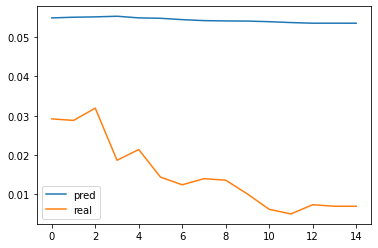

In [15]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

plt.plot(np.array(out)[:,0],label = 'pred')
plt.plot(np.array(out)[:,1],label = 'real')
plt.legend()